In [44]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
        
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

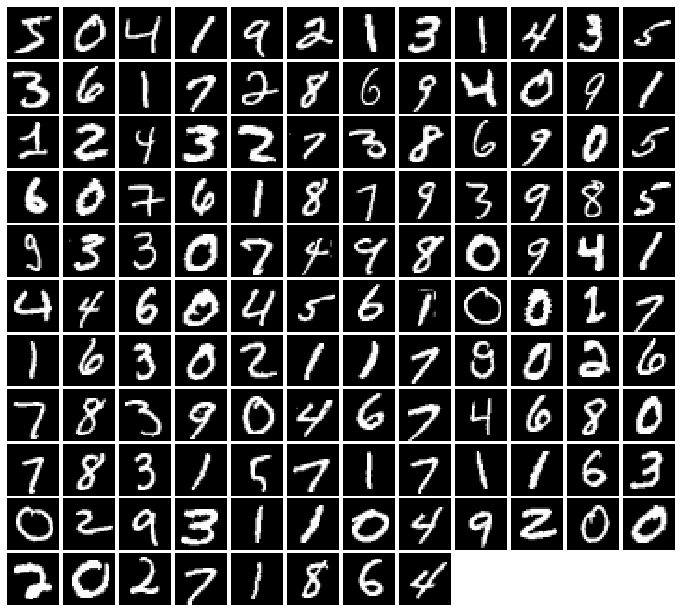

In [45]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./MNIST_data/', train=True, download=False,
                           transform=T.ToTensor())

loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./MNIST_data/', train=True, download=False,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

In [46]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    return torch.FloatTensor(batch_size, dim).uniform_(-1, 1)

In [47]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

In [48]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

In [49]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    return torch.FloatTensor(batch_size, dim).uniform_(-1, 1)

In [50]:
def discriminator():
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(Unflatten(N=-1,C=1,H=28,W=28),
                          nn.Conv2d(in_channels=1, out_channels=32,kernel_size=5, stride=1),
                          nn.LeakyReLU(0.01),
                          nn.MaxPool2d(kernel_size=2,stride=2),
                          nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1),
                          nn.LeakyReLU(0.01),
                          nn.MaxPool2d(kernel_size=2,stride=2),
                          Flatten(),
                          nn.Linear(4*4*64,4*4*64),
                          nn.LeakyReLU(0.01),
                          nn.Linear(4*4*64,1)
                         )
    return model

In [51]:
def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential( nn.Linear(noise_dim,1024),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm1d(1024),
                           nn.Linear(1024,7*7*128),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm1d(7*7*128),
                           Unflatten(),
                           nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(64),
                           nn.ConvTranspose2d(in_channels=64,out_channels=1,kernel_size=4,stride=2,padding=1),
                           nn.Tanh(),
                           Flatten()
                         )
    return model

In [52]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    N,_ = scores_real.size()
    loss = (0.5 * torch.mean((scores_real-torch.ones(N).type(dtype))**2)) + (0.5 * torch.mean(scores_fake**2))
    return loss

In [53]:
def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    N,_ = scores_fake.size()
    loss = (0.5 * torch.mean((scores_fake-torch.ones(N).type(dtype))**2))
    return loss

In [54]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr = 1e-3, betas = (0.5,0.999))
    return optimizer

In [92]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    d_loss_list=[]
    g_loss_list=[]
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)
            
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()
            if (iter_count % 10 ==0):
                d_loss_list.append(d_total_error)
                g_loss_list.append(g_error)
            
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
            iter_count += 1
    return d_loss_list,g_loss_list

Iter: 0, D: 0.3947, G:1.747


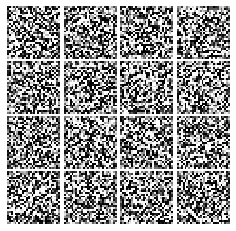

Iter: 150, D: 0.2106, G:0.1965


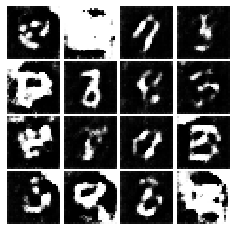

Iter: 300, D: 0.1852, G:0.2167


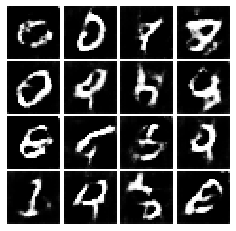

Iter: 450, D: 0.1837, G:0.1258


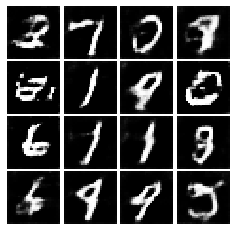

Iter: 600, D: 0.1914, G:0.2269


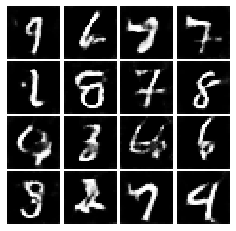

Iter: 750, D: 0.1801, G:0.1957


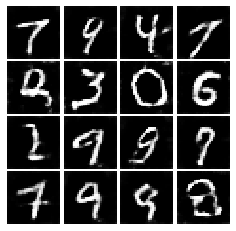

Iter: 900, D: 0.3293, G:0.0951


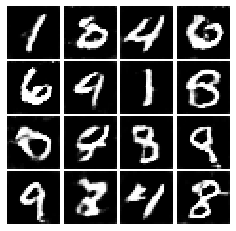

Iter: 1050, D: 0.2211, G:0.1619


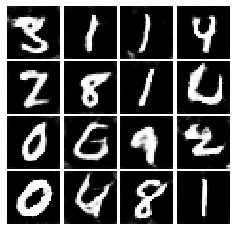

Iter: 1200, D: 0.197, G:0.1725


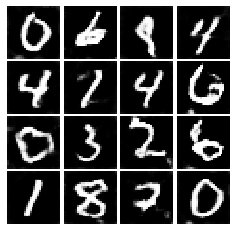

Iter: 1350, D: 0.2091, G:0.1713


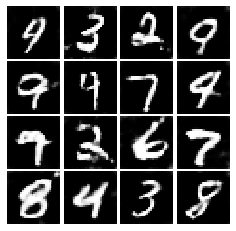

Iter: 1500, D: 0.1935, G:0.2047


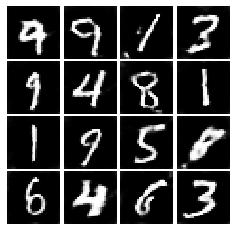

Iter: 1650, D: 0.2185, G:0.206


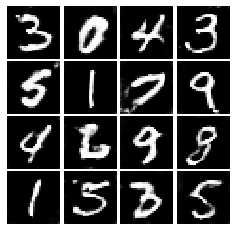

Iter: 1800, D: 0.1802, G:0.2182


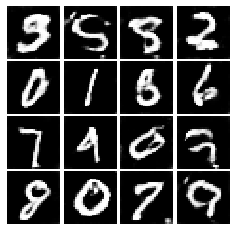

In [93]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

d_loss_list, g_loss_list=run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss,show_every=150,num_epochs=5)

<function matplotlib.pyplot.show(close=None, block=None)>

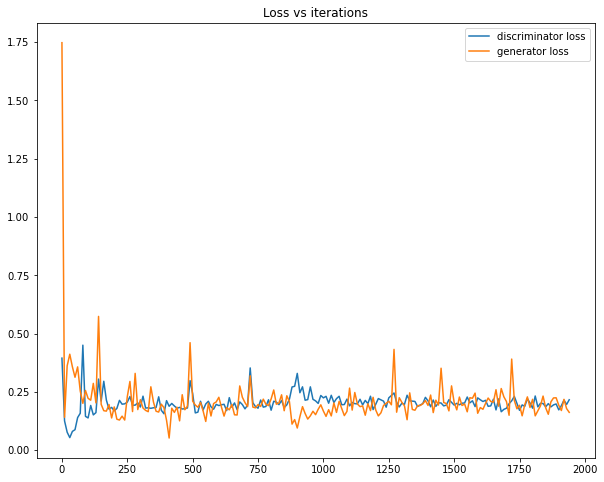

In [99]:
plt.plot([i*10 for i in range(len(d_loss_list))],[i.detach().tolist() for i in d_loss_list],label='discriminator loss')
plt.plot([i*10 for i in range(len(d_loss_list))],[i.detach().tolist() for i in g_loss_list],label='generator loss')
plt.legend()
plt.title('Loss vs iterations')
plt.show

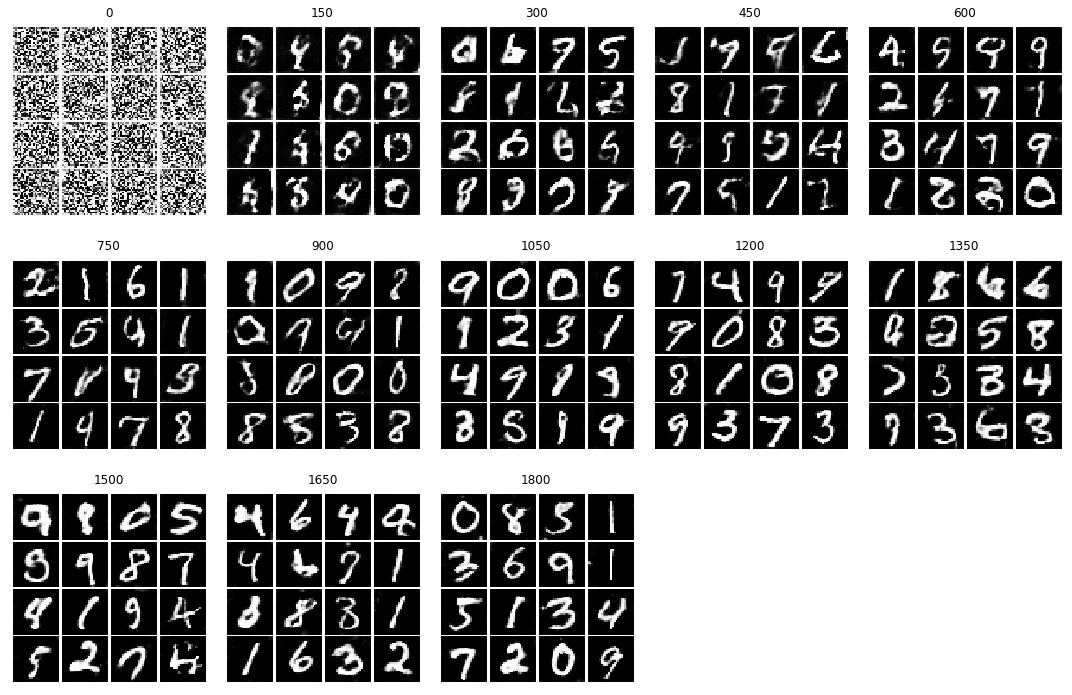

In [88]:
import os 
import matplotlib.pyplot as plt

n_plots = len(os.listdir('./results'))
fig,ax = plt.subplots(n_plots//5+1,5,figsize=(15,10))

for idx in range(n_plots):
    img=plt.imread(f'./results/{idx*150}.png')
    ax[idx//5][idx%5].axis('off')
    ax[idx//5][idx%5].imshow(img)
    ax[idx//5][idx%5].set_title(idx*150)
for idx in range(idx+1,(n_plots//5+1)*5): 
    ax[idx//5][idx%5].set_visible(False)

plt.tight_layout()
plt.show()